## Intro to LSST DP1

The goal of this notebook is to demonstrate the use of the first data products released from LSST -- the Data Preview 1. These observations were acquired during Nov - Dec 2024 using the LSST Commissioning Camera -- basically using 1 of the 21 CCD mosaics in the full camera, and placed at the center of the field of view. More details about the commissioning camera [here](https://lsstcomcam.lsst.io/index.html).

The data were processed through the standard LSST pipeline and the products were publicly made available on June 30, 2025. Although the actual LSST data stream will consistent of alert "packets" (similar to ZTF) that can filtered on, the DP1 products allow us to directly query the backend database in SQL-like format and perform very similar operations. 

The goals of this notebook are to 
* Provide a visual introduction to LSST Comcam data, and demonstrate the dramatic improvement over exisiting surveys
* Show examples of ways to utilize this data for both quasi-variable and transient sources
* Simulate a real LSST-like (i.e. slower cadence) time series to visualize what actual LSST data will look like

Builds heavily on the candidate transient identification notebooks provided as part of the LSST DP1 tutorials.

## Required Modules
Since we are running within the RSP, we do not have to worry about installing invidual modules; instead, we will import them directly on the platform. 

In [2]:
#lets import the main modules we'll need for the tutorial
import matplotlib.pyplot as plt
from astropy.coordinates import Angle
import astropy.units as u
from astropy.time import Time

import pandas as pd
import requests
from io import StringIO, BytesIO
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch
import numpy as np

import lsst.afw.display as afwDisplay
from lsst.afw.image import ExposureF
from lsst.afw.fits import MemFileManager

from lsst.rsp.service import get_siav2_service
from lsst.rsp.utils import get_pyvo_auth

from pyvo.dal.adhoc import DatalinkResults, SodaQuery
import lsst.geom as geom

## Comparing LSST to its predecessors

With its real-time alert stream, the Zwicky Transient Facility (ZTF) presents a fairly good comparison for a precursor LSST dataset, and has been widely used in the community for time domain science. However, ZTF was on a much smaller telescope (but with larger field of view), allowing it to probe somewhat different parameter space in the transient landscape.

Naturally a good starting point is to compare ZTF and LSST directly, and see the improvements in making this jump. Although the two are in different hemispheres, a large fraction of the DP1 [Observations](https://dp1.lsst.io/overview/observations.html) happened to be in a part of the sky where both ZTF and LSST have coverage -- the Extended Chandra Deep Field South (ECDFS). This is also the field with the maximum number of observations in DP1, and therefore we will focus on this field to start with this notebook. 

Let's begin by just plotting a visual image of the center of ECDFS field as seen by ZTF and LSST. First, we'll pull the archival ZTF single visit images from the [IRSA](https://irsa.ipac.caltech.edu/Missions/ztf.html) database.

Querying IRSA metadata...
Fetching cutout from:
https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2021/0108/211134/ztf_20210108211134_000252_zr_c02_o_q3_sciimg.fits?center=53.1246023,-27.7404715&size=216arcsec&gzip=false


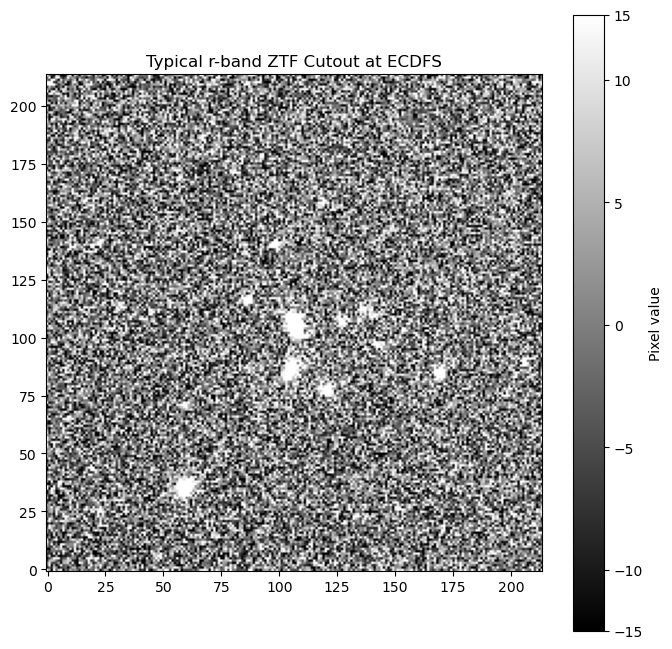

In [3]:
# Target coordinates (ECDFS)
target_ra = 53.1246023
target_dec = -27.7404715

# Step 1: Query metadata from IRSA
metadata_url = (
    f"https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci"
    f"?POS={target_ra},{target_dec}"
    "&SIZE=0.1"
    "&INTERSECT=OVERLAPS"
    "&COLUMNS=filefracday,field,filtercode,ccdid,qid,imgtypecode,maglimit"
    "&ct=csv"
)

print("Querying IRSA metadata...")
response = requests.get(metadata_url)
response.raise_for_status()
df = pd.read_csv(StringIO(response.text), comment="#")

# Step 2: Select a random r-band (zr) image
df_r = df[df["filtercode"] == "zr"]
if df_r.empty:
    raise RuntimeError("No r-band images found at this position.")
row = df_r.sample(n=1).iloc[0]

# Step 3: Extract metadata
filefracday = str(row["filefracday"])
field = str(row["field"]).zfill(6)
filtercode = row["filtercode"]
ccdid = f"{int(row['ccdid']):02d}"
qid = f"{int(row['qid'])}"
imgtypecode = row["imgtypecode"]
year, month, day = filefracday[:4], filefracday[4:6], filefracday[6:8]
fracday = filefracday[8:]

filename = f"ztf_{filefracday}_{field}_{filtercode}_c{ccdid}_{imgtypecode}_q{qid}_sciimg.fits"
cutout_url = (
    f"https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/"
    f"{year}/{month}{day}/{fracday}/{filename}"
    f"?center={target_ra},{target_dec}&size=216arcsec&gzip=false"
)

print(f"Fetching cutout from:\n{cutout_url}")
cutout_response = requests.get(cutout_url)
cutout_response.raise_for_status()

# Step 4: Display FITS cutout
hdul = fits.open(BytesIO(cutout_response.content))
image_data = hdul[0].data
image_data -= np.median(image_data)

vmin = np.percentile(image_data, 10)
vmax = np.percentile(image_data, 90)
norm = ImageNormalize(image_data, vmin=vmin, vmax=vmax, stretch=LinearStretch(), clip=True)
plt.figure(figsize=(8, 8))
plt.imshow(image_data, origin="lower", cmap="gray", norm=norm)
plt.title("Typical r-band ZTF Cutout at ECDFS")
plt.colorbar(label="Pixel value")
plt.grid(False)
plt.show()


And there we see a nice image of a few faint galaxies right at the center of the field. Recall that the typical depth of ZTF is about r ~ 20.5 mag with a pixel scale of 1"/pixel, and most of these objects (even visually) appear close to the detection threshold. Comparatively, LSST single band visits are projected to be ~4 mags (40X) deeper with pixels that are 5 times finer (0.2"/pixel; or 25X smaller area per pixel). 

Let's see how than pans out in real data by directly pulling data from DP1!

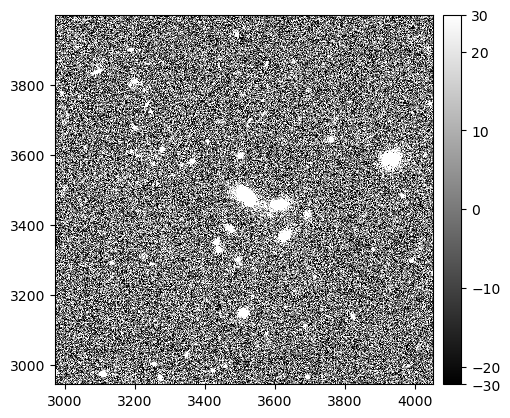

In [4]:
# Set display backend
afwDisplay.setDefaultBackend("matplotlib")

# Define ECDFS cutout parameters
target_ra = 53.1246023
target_dec = -27.7404715
eff_wl = 622.1e-09  # meters
time1 = Time(60600.256, format="mjd", scale="tai")
time2 = Time(60700.259, format="mjd", scale="tai")
search_radius = 0.01  # degrees

# Connect to DP1 SIA service
service = get_siav2_service("dp1")
assert service is not None

# SIA query for visit image
circle = (target_ra, target_dec, search_radius)
results = service.search(pos=circle, calib_level=2, dpsubtype='lsst.visit_image',
                         band=eff_wl, time=(time1, time2))
assert len(results) > 0, "No visit image found."

# Get datalink and build SODA query
datalink_url = results[3].access_url
dl_result = DatalinkResults.from_result_url(datalink_url, session=get_pyvo_auth())
soda = SodaQuery.from_resource(dl_result,
                               dl_result.get_adhocservice_by_id("cutout-sync"),
                               session=get_pyvo_auth())

# Define cutout center and radius
spherePoint = geom.SpherePoint(target_ra * geom.degrees, target_dec * geom.degrees)
cutout_radius = 0.03* u.deg #108 arcsec

soda.circle = (spherePoint.getRa().asDegrees() * u.deg,
               spherePoint.getDec().asDegrees() * u.deg,
               cutout_radius)

# Execute the cutout request and load into ExposureF
cutout_bytes = soda.execute_stream().read()
soda.raise_if_error()
mem = MemFileManager(len(cutout_bytes))
mem.setData(cutout_bytes, len(cutout_bytes))
exposure = ExposureF(mem)

image_array = exposure.image.array
vmin = np.percentile(image_array, 10)
vmax = np.percentile(image_array, 90)

display = afwDisplay.Display()
display.scale('linear', vmin, vmax)
display.mtv(exposure)

display.image(exposure.image)


Dang! As you can see, LSST provides superior depth and spatial resolution compared to ZTF. What we've shown here is a single band, single visit LSST image cutout -- however, real LSST users will (mostly) not need to use the images directly but instead rely on the data products derived from these images (source positions, brightnesses etc). With this brief demonstration of the increased depth, we are ready to start exploring the data products directly!

## Understanding the DP1 data products

DP1 provides both a catalog of time-resolved source positions, brightnesses derived from the science images (i.e. images like the one above) and the same derived from difference imaging (i.e. taking the above image and subtracting a template image in the same filter taken some time before). For this exercise, we are going to focus just on the products from difference imaging; further details on all the data products can be found [here](https://dp1.lsst.io/products/index.html). For the difference imaging analysis (DIA), we have to primarily focus on two types of product -- the DIAObjects and the DIASources. 


As detailed in the release description, a A “DIA source” is a signal-to-noise ratio > 5 detection in a difference image, containing measurements on a difference image at the coordinates of every source detected in that difference image. A “DIA object” is an astrophysical transient or variable object at a static sky coordinate, created by associating DIA sources within a 1 arcsecond radius. Therefore, there can be multiple DIASources associated to the same DIAObject (which is fixed in sky coordinate).

Let's begin exploring this with the dataset itself.

### Define parameters and functions
Create an instance of the TAP service, and assert that it exists.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from lsst.rsp import get_tap_service
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols)

from pyvo.dal.adhoc import DatalinkResults, SodaQuery

In [9]:
service = get_tap_service("tap")
assert service is not None

Define filter names, plot markers, linestyles, and colors for plotting

In [10]:
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = {'u':'b', 'g':'g', 'r':'r', 'i':'y', 'z':'darkorange', 'y':'m'}
filter_symbols = {'u':'o', 'g':'o', 'r':'o', 'i':'o', 'z':'o', 'y':'o'}
print(filter_colors, filter_symbols)

{'u': 'b', 'g': 'g', 'r': 'r', 'i': 'y', 'z': 'darkorange', 'y': 'm'} {'u': 'o', 'g': 'o', 'r': 'o', 'i': 'o', 'z': 'o', 'y': 'o'}


### Get a sample of DiaObjects

Define the coordinates (RA and Dec) of the center of the Extended Chandra Deep Field-South field (ECDFS), which is the best-observed field in DP1.

In [11]:
ra = 53.13
dec = -28.10

Define the TAP query for a 2-degree cone search of the ECDFS for transient candidates in the `DiaObject` table, which contains useful light curve statistics. Of the six bands, the ECDFS field was covered most by the *r*-band (See Table 3 of RTN-011). The candidate search will therefore utilize *r*-band light curve properties.

In [12]:
query = "SELECT ra, dec, diaObjectId, "\
        "nDiaSources, r_scienceFluxMean, g_scienceFluxMean, "\
        "r_psfFluxNdata, g_psfFluxNdata "\
        "FROM dp1.DiaObject "\
        "WHERE CONTAINS (POINT('ICRS', ra, dec), "\
        "CIRCLE('ICRS'," + str(ra) + ", "\
        + str(dec) + ", 2)) = 1 "
print(query)

SELECT ra, dec, diaObjectId, nDiaSources, r_scienceFluxMean, g_scienceFluxMean, r_psfFluxNdata, g_psfFluxNdata FROM dp1.DiaObject WHERE CONTAINS (POINT('ICRS', ra, dec), CIRCLE('ICRS',53.13, -28.1, 2)) = 1 


Run the TAP search and fetch the results in table form.

In [13]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()
assert job.phase == 'COMPLETED'
DiaObjsFull = job.fetch_result().to_table()

Job phase is COMPLETED


### Review DiaObject characteristics

Plot the histogram distribution of DiaSources per DiaObject (i.e., the total number of $\geq5\sigma$ detections in difference images per DiaObject; at left), and the distribution of the number of `r`-band detections per DiaObject (at right).

Notice how the distribution is peaked at small numbers of DiaSources (and `r`-band detections) -- these are either artifacts from single difference images or time-variable sources that were only detected in a few difference images, and are most likely to have a faint time-variable flux.

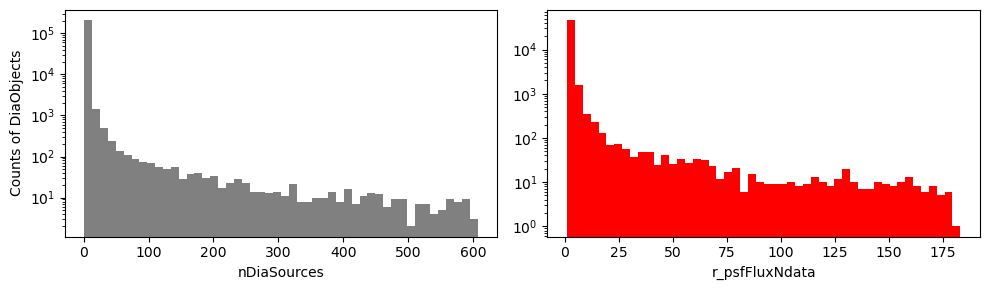

Total number of unique variable/transient sources 210535


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(DiaObjsFull['nDiaSources'], bins=50, log=True, color='gray')
ax[0].set_xlabel('nDiaSources')
ax[0].set_ylabel('Counts of DiaObjects')

ax[1].hist(DiaObjsFull['r_psfFluxNdata'], bins=50, log=True, color=filter_colors['r'])
ax[1].set_xlabel('r_psfFluxNdata')

plt.tight_layout()
plt.show()

print('Total number of unique variable/transient sources', len(DiaObjsFull))

Remember that the distribution represents only the "detections" in the difference images; if a source was constant or the variability (with respect to the template image) was statisically insignificant, those observations would not show up on these histograms even if the source was visually present in the un-subtracted images. Regardless, we see that there are > 200K variable sources even within this tiny < 0.5 sq deg. footprint of the Comcam. 

In order to see a set of bonafide variables, we'll first apply some simple cuts on the full objects table to reduce it to objects that are consistently detected in multiple epochs. We'll apply the following criteria

Filter the full DiaObject results (defined as `DiaObjsFull`) with the following conditions:
* `r_scienceFluxMean` < $10^{5.5}$ nJy & `g_scienceFluxMean` < $10^{5.5}$ nJy: Candidate exhibits fluxes sufficiently below saturation limits
* `r_psfFluxNdata` > 2 & `g_psfFluxNdata` > 2: Candidate has more than 2 *r*-band detections and more than 2 *g*-band detections


In [15]:
DiaObjs = DiaObjsFull[(DiaObjsFull['r_scienceFluxMean'] < 10**5.5) & (DiaObjsFull['g_scienceFluxMean'] < 10**5.5)]
DiaObjs = DiaObjs[(DiaObjs['r_psfFluxNdata'] > 2) & (DiaObjs['g_psfFluxNdata'] > 2)]

print(str(len(DiaObjs))+' consistently detected sources.')

2390 consistently detected sources.


As we can see, even with that simple cut of requiring multiple detections, we've substantially reduced the number of consistently detected sources. Let's go ahead and look at the contents of the table

In [16]:
DiaObjs

<Table length=2390>
        ra                 dec         ... r_psfFluxNdata g_psfFluxNdata
       deg                 deg         ...                              
     float64             float64       ...    float64        float64    
------------------ ------------------- ... -------------- --------------
 53.40901451714177  -28.60296337454877 ...            6.0            9.0
53.747253419317836  -28.29846931152263 ...            9.0            4.0
 53.69719957089513  -28.40292093470981 ...            5.0            4.0
  53.7240952001311 -28.410337995839793 ...            4.0            3.0
 53.70998946381662  -28.06879903451784 ...           22.0            6.0
  53.6698647776145  -28.11481493261206 ...            4.0            3.0
 53.69803727998473  -28.14032484954251 ...           17.0            4.0
 53.74588425459366  -28.17533653884292 ...           16.0            5.0
 53.72925593954778  -28.08590851363426 ...           19.0           13.0
               ...                 ... ...            ...            ...
 53.10088169551192 -27.958785040138732 ...            5.0            3.0
53.272215827659856 -27.857264081736396 ...            3.0            7.0
 53.20199029599091 -28.002096875752137 ...            8.0           15.0
53.102106656193456   -28.0074032892828 ...           12.0            6.0
  53.0900189430173 -27.962484451213356 ...            4.0            3.0
 53.19619489957941 -27.922285516352108 ...            9.0            4.0
53.269882840794224  -28.01571442835097 ...            3.0            3.0
 53.17655951383512 -27.949241968519264 ...            6.0            4.0
 53.27012573654175  -27.97853608541257 ...            5.0            9.0

For this cleaner subset, we are interested in what their long-term variability looks like; however the DIASource measurments **exist only** when the sources have statistically significant difference fluxes. Therefore, we will instead use the DIA forced photometry measurements stored in the ForcedSourceOnDiaObject object. This table contains forced photometry measurements on *every* DIAObject in the table and on *every* difference image that was recorded.

In [17]:
cand_list = "(" + ", ".join(str(value) for value in DiaObjs['diaObjectId']) + ")"

query = "SELECT fsodo.coord_ra, fsodo.coord_dec, "\
        "fsodo.diaObjectId, fsodo.visit, fsodo.band, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "vis.expMidptMJD "\
        "FROM dp1.ForcedSourceOnDiaObject as fsodo "\
        "JOIN dp1.Visit as vis ON vis.visit = fsodo.visit "\
        "WHERE diaObjectId IN {}" \
        "ORDER BY diaObjectId ASC".format(cand_list)
print(query)

SELECT fsodo.coord_ra, fsodo.coord_dec, fsodo.diaObjectId, fsodo.visit, fsodo.band, fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, vis.expMidptMJD FROM dp1.ForcedSourceOnDiaObject as fsodo JOIN dp1.Visit as vis ON vis.visit = fsodo.visit WHERE diaObjectId IN (609788117972418746, 609789354922999839, 609788667728232478, 609788667728232473, 611254179289104391, 611254179289104394, 611254179289104399, 611254179289104447, 611254179289104443, 611254179289104446, 611254179289104472, 611254179289104478, 611253492094337042, 611253492094337034, 611253492094337043, 611253492094337026, 611253492094337071, 611253492094337074, 611253492094337078, 611253492094337053, 611253492094337052, 611253492094337054, 611253492094337055, 611253492094337081, 609780833707884555, 609780764988407833, 609780764988407829, 609788186691895944, 609788186691895752, 609788186691895731, 609788186691895729, 609788186691895830, 609788186691895764, 609788255411372119, 609788255411372113, 609788255411372145, 609788255411372138, 609788

In [18]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Job phase is COMPLETED


In [19]:
assert job.phase == 'COMPLETED'
FrcdSrc = job.fetch_result().to_table()

## Detecting variability in known variables

Given the large size of the number of variable sources, a natural starting point is to ask -- what does a typical variable source look like? As we commonly hear amongst transient astronomers -- *AGN are the vermin of the variable sky* and we can start by examining the light curves of known AGN in this footprint! We'll crossmatch out list of DIAObjects with the [Milliquas](https://ui.adsabs.harvard.edu/abs/arXiv:2308.01505) catalog on Vizier and see how they look.

In [20]:
from astroquery.vizier import Vizier
from astropy.table import Table, hstack
from astropy.coordinates import SkyCoord

In [32]:
# Set up
Vizier.ROW_LIMIT = -1
search_radius = 2 * u.arcsec

# SkyCoord for your DiaObjs (LSST)
dia_coords = SkyCoord(ra=DiaObjs['ra'].to(u.deg).value * u.deg,
                      dec=DiaObjs['dec'].to(u.deg).value * u.deg)

# Query Milliquas for all positions
result = Vizier.query_region(dia_coords, radius=search_radius, catalog='VII/294')

if len(result) == 0:
    print("No matches found in Milliquas.")
    matched_table = Table()
else:
    milliquas = result[0]

    # SkyCoord for Milliquas results
    mq_coords = SkyCoord(ra=milliquas['RAJ2000'], dec=milliquas['DEJ2000'], unit='deg')

    # Match Milliquas sources to nearest LSST DIAObject
    idx, sep2d, _ = mq_coords.match_to_catalog_sky(dia_coords)

    # Keep only good matches
    matched_mq = milliquas
    matched_dia = DiaObjs[idx]

    # Combine both tables
    matched_table = hstack([matched_dia, matched_mq])

    print(f"Matched {len(matched_table)} DIAObjects to Milliquas.")

print(matched_table)

Matched 76 DIAObjects to Milliquas.
        ra                 dec         ...         Lobe2         
       deg                 deg         ...                       
------------------ ------------------- ... ----------------------
 53.70415705167852  -28.19588337434579 ...                       
53.676792994098584 -28.257937611320685 ...                       
52.574181123958354  -28.04202406297253 ...                       
 52.67389278274378  -27.94960403287912 ...                       
 52.75486739012758 -27.857066201892025 ...                       
53.512341081606756 -28.009590206156712 ...                       
 53.65666959497704 -27.974161740283176 ...                       
53.492892354253975  -27.81355352160308 ... LSXPS J033358.3-274849
 53.54399924496049 -27.848591884137974 ...                       
               ...                 ... ...                    ...
   53.290560409754 -27.937289443173917 ... LSXPS J033309.7-275616
 53.13341532596238  -28.05278536788899 .

Not surprisingly, we see that there are multiple AGN in the Milliquas catalog that were detected as variables in this footprint! We can now proceed with plotting their light curves. Remember that fluxes in difference images are recorded in flux units, and may be positive or negative. In order for easier viewing, we convert the fluxes (originally in nJy) to AB magnitude units, deal with upper limits (i.e. no statistical evidence for positive flux) and plot them all together. 

DIAObject 609781589622128654 — Brightest detection: MJD=60627.27, band=z, mag=21.45
DIAObject 609781589622128861 — Brightest detection: MJD=60648.18, band=g, mag=23.06
DIAObject 609782208097419316 — Brightest detection: MJD=60648.20, band=i, mag=22.59
DIAObject 609782208097419393 — Brightest detection: MJD=60650.23, band=r, mag=23.20
DIAObject 609788117972418594 — Brightest detection: MJD=60632.08, band=z, mag=22.37
DIAObject 609788186691896072 — Brightest detection: MJD=60642.12, band=r, mag=23.39
DIAObject 609788736447709215 — Brightest detection: MJD=60651.10, band=i, mag=20.40
DIAObject 609788736447709277 — Brightest detection: MJD=60651.10, band=i, mag=22.58
DIAObject 609788805167185927 — Brightest detection: MJD=60624.32, band=u, mag=18.84
DIAObject 609788805167186008 — Brightest detection: MJD=60652.19, band=r, mag=23.68
DIAObject 609788873886662802 — Brightest detection: MJD=60655.25, band=g, mag=21.75
DIAObject 609789492361953378 — Brightest detection: MJD=60643.07, band=r, ma

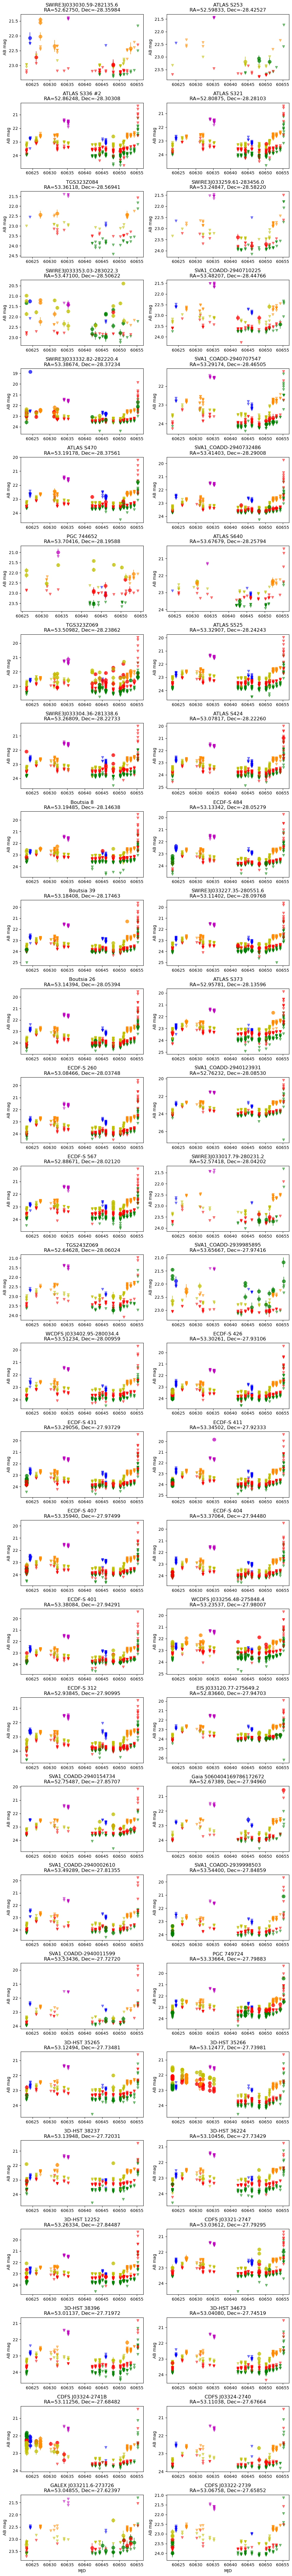

In [22]:
def flux_to_mag(flux_njy):
    return 31.4 - 2.5 * np.log10(flux_njy)

if len(result) > 0:
    matched_ids = np.unique(matched_table['diaObjectId'])
    n_objs = len(matched_ids)
    ncols = 2
    nrows = int(np.ceil(n_objs / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3 * nrows), sharex=False, sharey=False)
    axes = axes.reshape(-1)

    for idx in range(n_objs):
        ax = axes[idx]
        dia_id = matched_ids[idx]
        lc = FrcdSrc[FrcdSrc['diaObjectId'] == dia_id]

        # RA/Dec for title
        ra = DiaObjs[DiaObjs['diaObjectId'] == dia_id]['ra'][0]
        dec = DiaObjs[DiaObjs['diaObjectId'] == dia_id]['dec'][0]
        # Get Milliquas name from match table
        name = matched_table[matched_table['diaObjectId'] == dia_id]['Name'][0]
        ax.set_title(f"{name}\nRA={ra:.5f}, Dec={dec:.5f}")

        # Track brightest detection
        brightest_mag = np.inf
        brightest_mjd = None
        brightest_filt = None

        for filt in filter_names:
            band_lc = lc[lc['band'] == filt]
            good = (
                np.isfinite(band_lc['psfDiffFlux']) &
                np.isfinite(band_lc['psfDiffFluxErr']) &
                (band_lc['psfDiffFluxErr'] > 0)
            )
            band_lc = band_lc[good]
            if len(band_lc) == 0:
                continue

            flux = band_lc['psfDiffFlux']
            flux_err = band_lc['psfDiffFluxErr']
            mjd = band_lc['expMidptMJD']

            snr = flux / flux_err
            detections = (snr >= 5) & (flux > 0)
            upper_limits = ~detections

            if np.any(detections):
                mags = flux_to_mag(flux[detections])
                mag_err = 2.5 / np.log(10) * (flux_err[detections] / flux[detections])
                mjds = mjd[detections]
                ax.errorbar(mjds, mags, yerr=mag_err,
                            fmt=filter_symbols[filt],
                            color=filter_colors[filt], ms=8, alpha=0.7)

                # Brightest point
                min_idx = np.argmin(mags)
                if mags[min_idx] < brightest_mag:
                    brightest_mag = mags[min_idx]
                    brightest_mjd = mjds[min_idx]
                    brightest_filt = filt

            if np.any(upper_limits):
                flux_ul = 5 * flux_err[upper_limits]
                mags_ul = flux_to_mag(flux_ul)
                ax.plot(mjd[upper_limits], mags_ul,
                        marker='v', linestyle='None',
                        color=filter_colors[filt], alpha=0.5, ms=6)

        ax.invert_yaxis()
        ax.set_ylabel("AB mag")
        if idx >= (nrows - 1) * ncols:
            ax.set_xlabel("MJD")

        if brightest_mjd is not None:
            print(f"DIAObject {dia_id} — Brightest detection: MJD={brightest_mjd:.2f}, band={brightest_filt}, mag={brightest_mag:.2f}")

    # Remove unused axes
    for i in range(n_objs, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

Nice looking light curves, does anyone stand out? What is the source 3D-HST 35266 and CDFS J03324-2741B doing? Some kind of flare? We are already making discoveries in LSST data!

It is worth noticing that many of the time series have multiple observations in the same filter in a given night -- because these were commissioing observations, the cadence of the survey was not controlled and we end up getting very high cadence observations which are not necessarily useful. Going ahead, we will write a function that bins all observation fluxes taken within one night and re-plot the light curves for easier visualization. **This is much closer to what a real LSST time-series would look like**.

SWIRE3J033030.59-282135.6 — Brightest detection: MJD=60624.31, band=u, mag=22.28
ATLAS S253 — Brightest detection: MJD=60648.19, band=g, mag=23.10
ATLAS S336 #2 — Brightest detection: MJD=60626.08, band=r, mag=23.26
TGS323Z084 — Brightest detection: MJD=60627.27, band=z, mag=22.68
SWIRE3J033259.61-283456.0 — Brightest detection: MJD=60646.08, band=r, mag=24.15
SWIRE3J033353.03-283022.3 — Brightest detection: MJD=60650.65, band=i, mag=20.81
SVA1_COADD-2940710225 — Brightest detection: MJD=60648.18, band=r, mag=23.63
SWIRE3J033332.82-282220.4 — Brightest detection: MJD=60624.31, band=u, mag=21.11
SVA1_COADD-2940707547 — Brightest detection: MJD=60651.66, band=r, mag=23.99
ATLAS S470 — Brightest detection: MJD=60653.19, band=z, mag=23.56
SVA1_COADD-2940732486 — Brightest detection: MJD=60653.18, band=r, mag=23.95
PGC 744652 — Brightest detection: MJD=60634.06, band=y, mag=21.16
ATLAS S640 — Brightest detection: MJD=60631.21, band=z, mag=22.90
TGS323Z069 — Brightest detection: MJD=60651.22

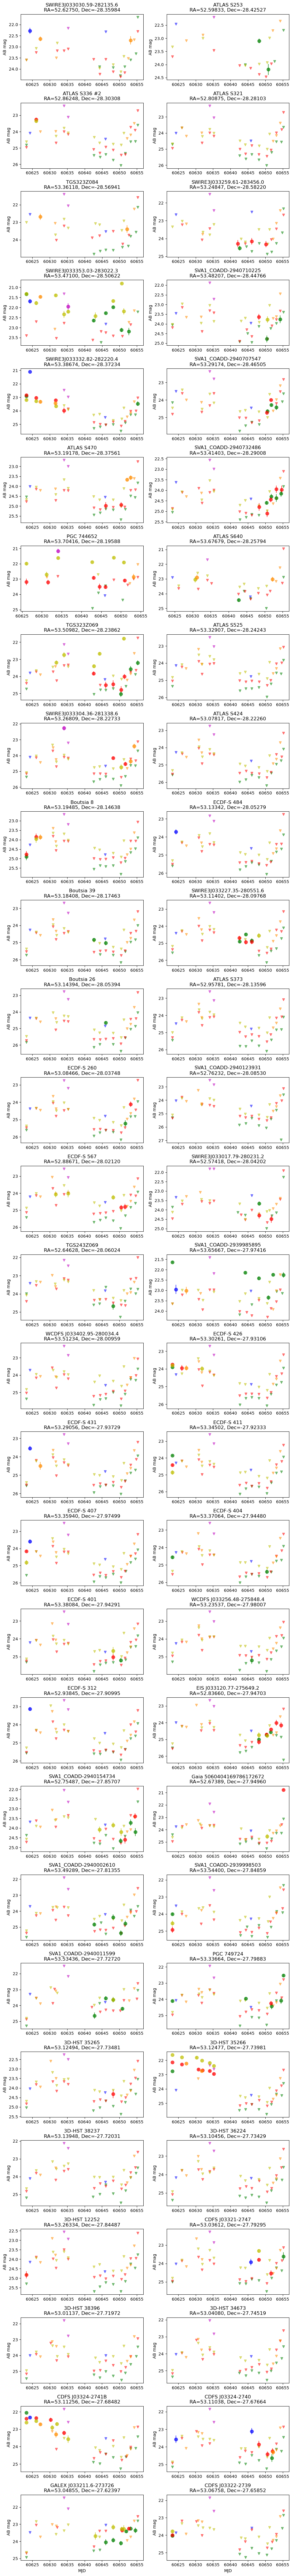

In [24]:
def bin_flux_time(mjd, flux, flux_err, bin_width=1.0):
    sort_idx = np.argsort(mjd)
    mjd = mjd[sort_idx]
    flux = flux[sort_idx]
    flux_err = flux_err[sort_idx]

    binned_mjd, binned_flux, binned_flux_err = [], [], []
    i = 0
    while i < len(mjd):
        start_time = mjd[i]
        j = i
        while j < len(mjd) and (mjd[j] - start_time) <= bin_width:
            j += 1

        mjd_bin = mjd[i:j]
        flux_bin = flux[i:j]
        err_bin = flux_err[i:j]
        weights = 1.0 / err_bin**2

        weighted_flux = np.sum(weights * flux_bin) / np.sum(weights)
        weighted_err = np.sqrt(1.0 / np.sum(weights))
        mean_mjd = np.mean(mjd_bin)

        binned_mjd.append(mean_mjd)
        binned_flux.append(weighted_flux)
        binned_flux_err.append(weighted_err)

        i = j

    return np.array(binned_mjd), np.array(binned_flux), np.array(binned_flux_err)

# Plotting binned light curves
matched_ids = np.unique(matched_table['diaObjectId'])
n_objs = len(matched_ids)
ncols = 2
nrows = int(np.ceil(n_objs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3 * nrows), sharex=False, sharey=False)
axes = axes.reshape(-1)

for idx in range(n_objs):
    ax = axes[idx]
    dia_id = matched_ids[idx]
    lc = FrcdSrc[FrcdSrc['diaObjectId'] == dia_id]

    ra = DiaObjs[DiaObjs['diaObjectId'] == dia_id]['ra'][0]
    dec = DiaObjs[DiaObjs['diaObjectId'] == dia_id]['dec'][0]
    name = matched_table[matched_table['diaObjectId'] == dia_id]['Name'][0]
    ax.set_title(f"{name}\nRA={ra:.5f}, Dec={dec:.5f}")

    brightest_mag = np.inf
    brightest_mjd = None
    brightest_filt = None

    for filt in filter_names:
        band_lc = lc[lc['band'] == filt]
        good = (
            np.isfinite(band_lc['psfDiffFlux']) &
            np.isfinite(band_lc['psfDiffFluxErr']) &
            (band_lc['psfDiffFluxErr'] > 0)
        )
        band_lc = band_lc[good]
        if len(band_lc) == 0:
            continue

        mjd = band_lc['expMidptMJD']
        flux = band_lc['psfDiffFlux']
        flux_err = band_lc['psfDiffFluxErr']

        # Bin within 1 day
        mjd_bin, flux_bin, flux_err_bin = bin_flux_time(mjd, flux, flux_err, bin_width=1.0)
        snr = flux_bin / flux_err_bin
        detections = (snr >= 5) & (flux_bin > 0)
        upper_limits = ~detections

        if np.any(detections):
            mags = flux_to_mag(flux_bin[detections])
            mag_err = 2.5 / np.log(10) * (flux_err_bin[detections] / flux_bin[detections])
            ax.errorbar(mjd_bin[detections], mags, yerr=mag_err,
                        fmt=filter_symbols[filt],
                        color=filter_colors[filt], ms=8, alpha=0.7)

            min_idx = np.argmin(mags)
            if mags[min_idx] < brightest_mag:
                brightest_mag = mags[min_idx]
                brightest_mjd = mjd_bin[detections][min_idx]
                brightest_filt = filt

        if np.any(upper_limits):
            flux_ul = 5 * flux_err_bin[upper_limits]
            mags_ul = flux_to_mag(flux_ul)
            ax.plot(mjd_bin[upper_limits], mags_ul,
                    marker='v', linestyle='None',
                    color=filter_colors[filt], alpha=0.5, ms=6)

    ax.invert_yaxis()
    ax.set_ylabel("AB mag")
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("MJD")

    if brightest_mjd is not None:
        print(f"{name} — Brightest detection: MJD={brightest_mjd:.2f}, band={brightest_filt}, mag={brightest_mag:.2f}")

# Clean up layout
for i in range(n_objs, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Untargeted searches for transients

Now that we've become a bit comfortable with querying the LSST data products, we can be a bit more adventurous and go searching for new ones. We see that looking at the single day binned light curves are somewhat easier when it comes to slower extragalactic sources. Although there are cases to look at the individual epochs, for the next exercise we will search these single day binned light curves

We will first begin with creating 1-day binned light curves for all the sources in the DIAObject table

In [25]:
from tqdm import tqdm

In [26]:
# Container for results
binned_rows = []

# Unique diaObjectIds
unique_ids = np.unique(FrcdSrc['diaObjectId'])

# Loop with progress bar
for dia_id in tqdm(unique_ids, desc="Binning light curves"):
    obj_lc = FrcdSrc[FrcdSrc['diaObjectId'] == dia_id]
    
    for band in np.unique(obj_lc['band']):
        band_lc = obj_lc[obj_lc['band'] == band]

        # Filter valid data
        good = (
            np.isfinite(band_lc['psfDiffFlux']) &
            np.isfinite(band_lc['psfDiffFluxErr']) &
            (band_lc['psfDiffFluxErr'] > 0)
        )
        band_lc = band_lc[good]
        if len(band_lc) == 0:
            continue

        mjd = band_lc['expMidptMJD']
        flux = band_lc['psfDiffFlux']
        flux_err = band_lc['psfDiffFluxErr']

        # Bin
        mjd_bin, flux_bin, flux_err_bin = bin_flux_time(mjd, flux, flux_err, bin_width=1.0)

        # Append results
        for mjd_i, flux_i, err_i in zip(mjd_bin, flux_bin, flux_err_bin):
            binned_rows.append((dia_id, band, mjd_i, flux_i, err_i))

# Create final table
binned_table = Table(rows=binned_rows, names=["diaObjectId", "band", "mjd", "psfDiffFlux", "psfDiffFluxErr"])


Binning light curves: 100%|██████████| 2390/2390 [02:56<00:00, 13.57it/s]


With this set, we can now proceed to applying specific selection criteria to the light curves themselves. In a typical transient survey, we try to look for things exploding in real-time, i.e. explosive transients that were not there before but appeared during the survey. One way to look for these things is to break down this criteria into pieces

* To find new things, we want the source to **not** have been detected at least once or twice before the first detection
* We want the source to be detected more than once after it is first detected
* Once it is detected, it should stay on for some time (to avoid contamination from sporadically varying sources like AGN).

With this light curve set, we will now define some functions to find things like these

In [27]:
def identify_flare_candidates(binned_table):
    """
    Identify flare candidates satisfying:
    - At least 2 non-detections before first detection in the trigger band
    - At least 2 detections (SNR > 5) in the trigger band
    - No SNR > 3 detections in any band before the flare time
    - Persistent detection in trigger band after flare
    """
    flare_candidates = []

    for dia_id in np.unique(binned_table['diaObjectId']):
        lc = binned_table[binned_table['diaObjectId'] == dia_id]
        band_names = np.unique(lc['band'])

        for band in band_names:
            band_lc = lc[lc['band'] == band]
            band_lc = band_lc[np.argsort(band_lc['mjd'])]
            snr = band_lc['psfDiffFlux'] / band_lc['psfDiffFluxErr']

            detect_idx = np.where(snr > 3)[0]
            if len(detect_idx) < 2:
                continue  # Require at least 2 detections in trigger band

            first_detect_idx = detect_idx[0]
            first_detect_mjd = band_lc['mjd'][first_detect_idx]

            # Require at least 2 non-detections before first detection in this band
            num_nondet_before = np.sum(snr[:first_detect_idx] < 5)
            if num_nondet_before < 2:
                continue

            # No detections in ANY band before this time
            preflare_all = lc[lc['mjd'] < first_detect_mjd]
            if np.any(preflare_all['psfDiffFlux'] / preflare_all['psfDiffFluxErr'] > 5):
                continue

            # Persistent detection in this band after flare
            if np.all(snr[first_detect_idx:] > 5):
                flare_candidates.append((dia_id, band))
                break  # only need one valid flare band

    return flare_candidates

flare_candidates = identify_flare_candidates(binned_table)
print('Found %d flare candidates'%len(flare_candidates))

Found 5 flare candidates


As we see here, applying this criteria remarkably reduces the number of sources to just five! Let's take a look at their light curves.

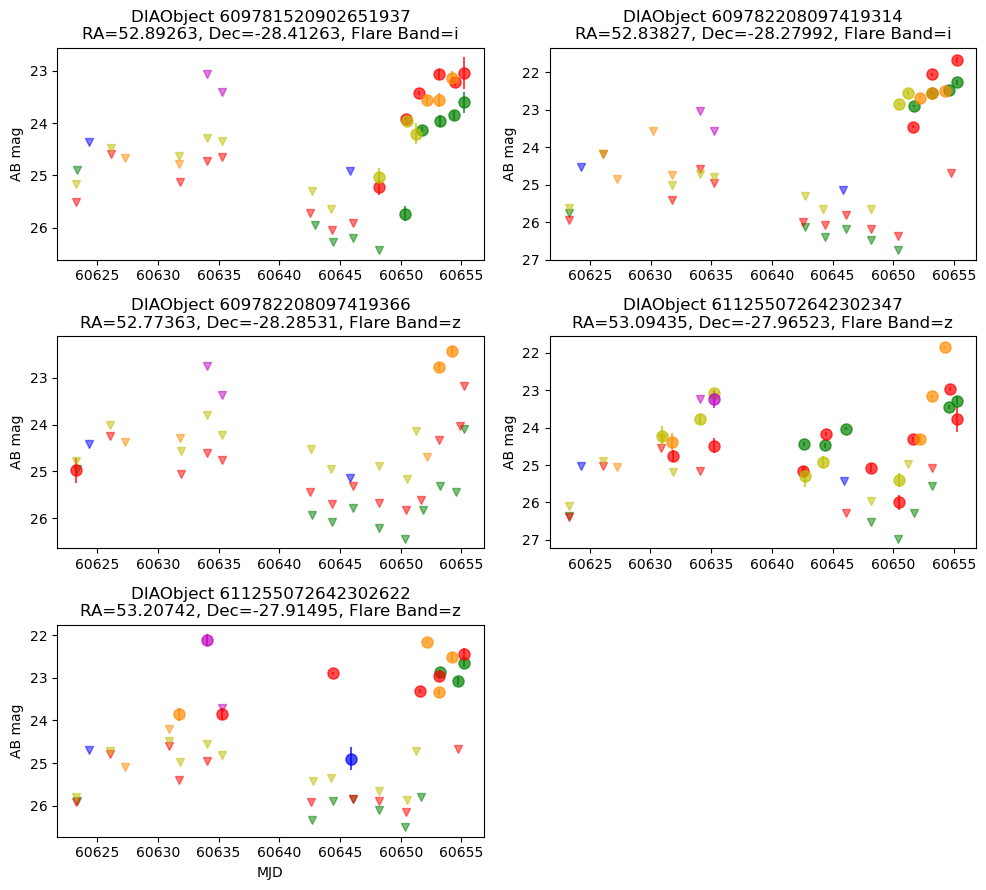

In [28]:
def plot_flare_candidates(binned_table, flare_candidates, DiaObjs=None):
    import matplotlib.pyplot as plt
    import numpy as np

    def flux_to_mag(flux_njy):
        return 31.4 - 2.5 * np.log10(flux_njy)

    n_objs = len(flare_candidates)
    ncols = 2
    nrows = int(np.ceil(n_objs / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3 * nrows))
    axes = axes.flatten()

    for idx, (dia_id, trigger_band) in enumerate(flare_candidates):
        ax = axes[idx]
        lc = binned_table[binned_table['diaObjectId'] == dia_id]

        # Optional RA/Dec in title
        if DiaObjs is not None and 'ra' in DiaObjs.colnames and 'dec' in DiaObjs.colnames:
            ra = DiaObjs[DiaObjs['diaObjectId'] == dia_id]['ra'][0]
            dec = DiaObjs[DiaObjs['diaObjectId'] == dia_id]['dec'][0]
            title = f"DIAObject {dia_id}\nRA={ra:.5f}, Dec={dec:.5f}, Flare Band={trigger_band}"
        else:
            title = f"DIAObject {dia_id}\nFlare Band={trigger_band}"
        ax.set_title(title)

        for filt in filter_names:
            band_lc = lc[lc['band'] == filt]
            if len(band_lc) == 0:
                continue

            mjd = band_lc['mjd']
            flux = band_lc['psfDiffFlux']
            flux_err = band_lc['psfDiffFluxErr']
            snr = flux / flux_err

            detections = (snr > 3) & (flux > 0)
            upper_limits = ~detections

            if np.any(detections):
                mags = flux_to_mag(flux[detections])
                mag_err = 2.5 / np.log(10) * (flux_err[detections] / flux[detections])
                ax.errorbar(mjd[detections], mags, yerr=mag_err,
                            fmt=filter_symbols[filt],
                            color=filter_colors[filt], label=filt,
                            ms=8, alpha=0.7)

            if np.any(upper_limits):
                flux_ul = 3 * flux_err[upper_limits]
                mags_ul = flux_to_mag(flux_ul)
                ax.plot(mjd[upper_limits], mags_ul,
                        marker='v', linestyle='None',
                        color=filter_colors[filt], alpha=0.5, ms=6)

        ax.invert_yaxis()
        ax.set_ylabel("AB mag")
        if idx >= (nrows - 1) * ncols:
            ax.set_xlabel("MJD")

    for i in range(n_objs, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    
plot_flare_candidates(binned_table, flare_candidates, DiaObjs)

Look at those beautiful looking light curves! Clearly some bonafide transients appearing in the dataset.

**Exercise: Search public catalogs, are any of these known transients from other surveys?**

And of course, we should examine the image cutouts themselves to confirm that the transients exist. Let's review the brightest detection for the first object in r band to confirm the nature of the transient.

In [29]:
import lsst.geom as geom
from lsst.afw.math import Warper, WarperConfig
sia_service = get_siav2_service("dp1")
assert sia_service is not None

### Define a function to get cutouts

This section uses the SIA service to find images
and the image cutout service to create a "cutout triplet".
Both services are demonstrated in 100-level tutorials.

In [30]:
def get_cutout(dl_result, spherePoint, session, fov):
    sq = SodaQuery.from_resource(dl_result,
                                 dl_result.get_adhocservice_by_id("cutout-sync"),
                                 session=session)
    sphereRadius = fov * u.deg
    sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
                 spherePoint.getDec().asDegrees() * u.deg,
                 sphereRadius)
    cutout_bytes = sq.execute_stream().read()
    sq.raise_if_error()
    mem = MemFileManager(len(cutout_bytes))
    mem.setData(cutout_bytes, len(cutout_bytes))
    return ExposureF(mem)

Brightest detection: MJD=60650.53, Flux=941.36 nJy


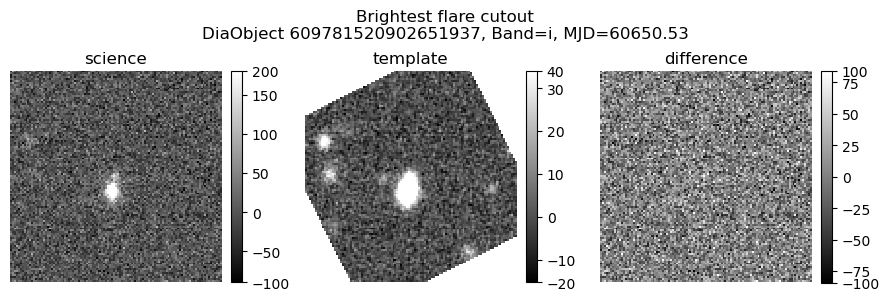

Brightest detection: MJD=60651.22, Flux=3423.39 nJy


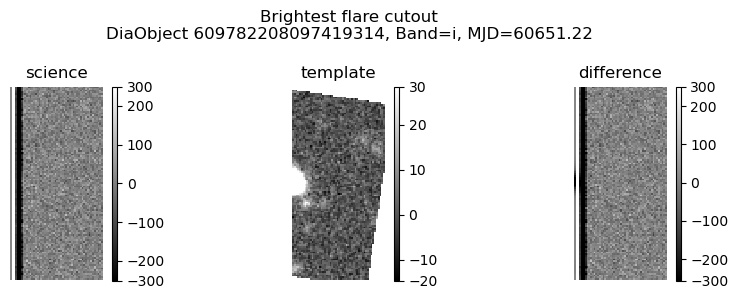

Brightest detection: MJD=60654.24, Flux=3914.03 nJy


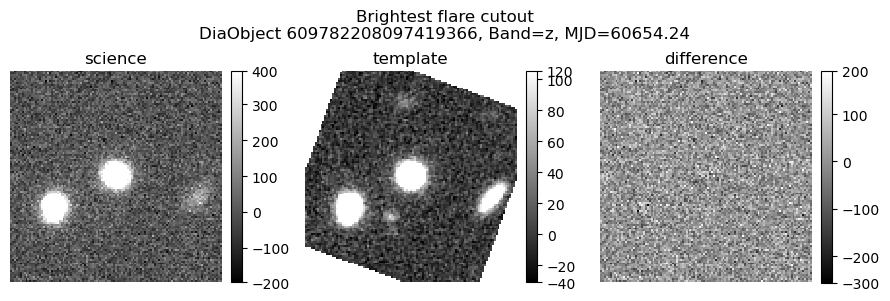

Brightest detection: MJD=60654.25, Flux=6621.13 nJy


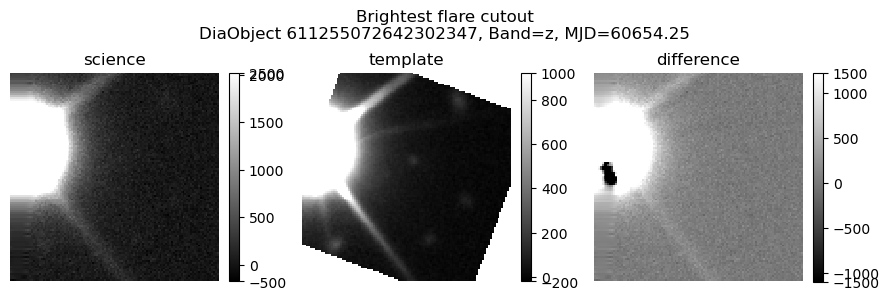

Brightest detection: MJD=60652.19, Flux=4944.52 nJy


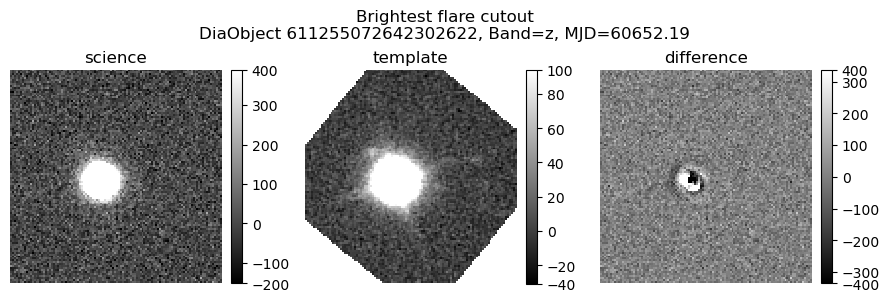

In [31]:

def plot_cutout_candidate(candid):
    # Step 1: First flare candidate
    flare_dia_id, trigger_band = flare_candidates[candid]
    
    # Step 2: Get RA, Dec
    row = DiaObjs[DiaObjs['diaObjectId'] == flare_dia_id][0]
    ra = row['ra']
    dec = row['dec']
    spherePoint = geom.SpherePoint(ra * geom.degrees, dec * geom.degrees)
    circle = (ra, dec, 0.001)


    # Step 3: Find brightest detection in the trigger band
    lc = binned_table[
        (binned_table['diaObjectId'] == flare_dia_id) &
        (binned_table['band'] == trigger_band)
    ]

    snr = lc['psfDiffFlux'] / lc['psfDiffFluxErr']
    valid = (snr > 5) & (lc['psfDiffFlux'] > 0)

    if not np.any(valid):
        print("No valid high SNR detections found.")
    else:
        brightest_idx = np.argmax(lc['psfDiffFlux'][valid])
        brightest_row = lc[valid][brightest_idx]
        brightest_mjd = brightest_row['mjd']
        print(f"Brightest detection: MJD={brightest_mjd:.2f}, Flux={brightest_row['psfDiffFlux']:.2f} nJy")

        # Step 4: Find matching science and diff images near that MJD
        results_sci = sia_service.search(pos=circle, calib_level=2)
        lvl2_table = results_sci.to_table()
        scitab = lvl2_table[
            (lvl2_table['dataproduct_subtype'] == 'lsst.visit_image') &
            (lvl2_table['lsst_band'] == trigger_band)
        ]
        scitab.sort('t_max')
        sci_row = scitab[np.argmin(np.abs(scitab['t_max'] - brightest_mjd))]

        results_lvl3 = sia_service.search(pos=circle, calib_level=3)
        lvl3_table = results_lvl3.to_table()

        reftab = lvl3_table[
            (lvl3_table['dataproduct_subtype'] == 'lsst.template_coadd') &
            (lvl3_table['lsst_band'] == trigger_band)
        ]
        difftab = lvl3_table[
            (lvl3_table['dataproduct_subtype'] == 'lsst.difference_image') &
            (lvl3_table['lsst_band'] == trigger_band)
        ]
        difftab.sort('t_max')
        diff_row = difftab[np.argmin(np.abs(difftab['t_max'] - brightest_mjd))]

        # Step 5: Download cutouts
        dl_sci = DatalinkResults.from_result_url(sci_row['access_url'], session=get_pyvo_auth())
        dl_ref = DatalinkResults.from_result_url(reftab['access_url'][-1], session=get_pyvo_auth())
        dl_diff = DatalinkResults.from_result_url(diff_row['access_url'], session=get_pyvo_auth())

        fov = 0.003
        sci = get_cutout(dl_sci, spherePoint, get_pyvo_auth(), fov)
        ref = get_cutout(dl_ref, spherePoint, get_pyvo_auth(), fov)
        diff = get_cutout(dl_diff, spherePoint, get_pyvo_auth(), fov)

        # Warp template
        warper_config = WarperConfig()
        warper = Warper.fromConfig(warper_config)
        warped_ref = warper.warpExposure(sci.getWcs(), ref, destBBox=sci.getBBox())

        # Plot cutouts
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        titles = ['science', 'template', 'difference']
        images = [sci.image, warped_ref.image, diff.image]

        for i in range(3):
            plt.sca(ax[i])
            display = afwDisplay.Display(frame=fig)
            display.scale('linear', 'zscale')
            display.mtv(images[i])
            plt.title(titles[i])
            ax[i].set_axis_off()

        fig.suptitle(f'Brightest flare cutout\nDiaObject {flare_dia_id}, Band={trigger_band}, MJD={np.round(brightest_mjd, 2)}')
        plt.tight_layout()
        plt.show()

for i in range(len(flare_candidates)):
    plot_cutout_candidate(i)

The cutout confirms that we've identified some bonafide extragalactic supernovae on host galaxies! Now spend some time modifying this code to examine all the other sources. Are they all extragalactic?

## Repeat this exercise on other fields

With this basic setup for filtering on transient sources, we will spend the rest of the time applying this (or a similar) selection on two other files

* The Euclid Deep Field South 
* The Low Galactic Latitude field

## Bonus exercise 
### Think about alternative selections -- red transients? fading transients? nuclear transients?